# Professional Backtesting with Zipline

Zipline is an algorithmic trading simulator. It was built and maintained by Quantopian before being acquired by Robinhood in 2020. It’s is a professional backtesting framework which means you can use it for both research and live trading.

Start with the imports.

You’ll use pandas_datareader to get data to compare your strategy with the S&P 500, matplotlib for charting, and PyFolio for performance analysis.

In [9]:
import pandas as pd
import pandas_datareader.data as web

import matplotlib.pyplot as plt

from zipline import run_algorithm
from zipline.api import order_target, record, symbol
from zipline.finance import commission, slippage
from zipline.pipeline import Pipeline, CustomFactor
from zipline.pipeline.factors import Returns, AverageDollarVolume

import pyfolio as pf

import warnings
warnings.filterwarnings('ignore')

Since you’re building the backtest in Jupyter Notebook, you need to load the Zipline “magics.” Running this lets you run the Zipline command line right in your Notebook.

In [2]:
%load_ext zipline

Zipline creates data “bundles” for backtesting. You can build custom bundles to ingest any data you want.

Today, you’ll use the pre-built Quandl bundle to ingest price data between 2000 and 2018 for free.

Head over to [Nasdaq Data Link](https://data.nasdaq.com), sign up for a free account, and get your API key.

In [4]:
%env QUANDL_API_KEY xDyHwX-tdK94YKzTbhy1
! zipline ingest -b quandl

env: QUANDL_API_KEY=xDyHwX-tdK94YKzTbhy1
[2023-04-07T05:46:57-0600-INFO][zipline.data.bundles.core]
 Ingesting quandl
[2023-04-07T05:46:57-0600-INFO][zipline.data.bundles.quandl]
[2023-04-07T05:47:08-0600-INFO][zipline.data.bundles.quandl]
 Parsing raw data.
[2023-04-07T05:47:29-0600-INFO][zipline.data.bundles.quandl]
 Generating asset metadata.
Merging daily equity files:  [-----------------------------------#]  1731/Users/jason/opt/anaconda3/envs/newsletter/lib/python3.9/site-packages/zipline/data/bcolz_daily_bars.py:341: UserWarning: Ignoring 1 values because they are out of bounds for uint32:
             open  high   low  close        volume  ex_dividend  split_ratio
2011-04-11  1.79  1.84  1.55    1.7  6.674913e+09          0.0          1.0
  winsorise_uint32(raw_data, invalid_data_behavior, "volume", *OHLC)
Merging daily equity files:  [####################################]      
[2023-04-07T05:48:55-0600-INFO][zipline.data.bundles.quandl]
 Parsing split data.
[2023-04-07T05:48:

You will see Zipline working its magic to download the data and package it into highly efficient data stores.

Every Zipline strategy must have an initialize function. This is run at the beginning of the strategy.

Here, you set a counter to track the days, the symbol to trade, and set the commission and slippage models.

In [2]:
def initialize(context):
    context.i = 0
    context.asset = symbol("AAPL")

    context.set_commission(commission.PerShare(cost=0.01))
    context.set_slippage(slippage.FixedSlippage(spread=0.01))

Every Zipline strategy must also have a handle_data function.

This function is run at every “bar.” Depending on your data, it might run every minute or day. handle_data is where your strategy logic lives.

In today’s example, you will build a simple dual-moving average cross-over strategy.

In [3]:
def handle_data(context, data):
    # Skip first 300 days to get full windows
    context.i += 1
    if context.i < 50:
        return

    # Compute averages
    # data.history() has to be called with the same params
    # from above and returns a pandas dataframe.
    short_mavg = data.history(
        context.asset, 
        "price", 
        bar_count=14,
        frequency="1d"
    ).mean()
    
    long_mavg = data.history(
        context.asset,
        "price",
        bar_count=50,
        frequency="1d"
    ).mean()

    # Trading logic
    if short_mavg > long_mavg:
        # order_target orders as many shares as needed to
        # achieve the desired number of shares.
        order_target(context.asset, 100)
    elif short_mavg < long_mavg:
        order_target(context.asset, 0)

    # Save values for later inspection
    record(
        AAPL=data.current(context.asset, "price"),
        short_mavg=short_mavg,
        long_mavg=long_mavg,
    )

Use the counter to make sure there is enough data to compute the moving averages. If not, skip processing for the day.

If there is enough data, get 14 and 50 days’ worth of prices and calculate the moving average.

Then, execute the trading logic.

When the 14-day moving average crosses over a 50-day moving average, the strategy buys 100 shares. When the 14-day moving average crosses under the 50-moving average, it sells them.

In [4]:
def analyze(context, perf):
    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    perf.portfolio_value.plot(ax=ax1)
    ax1.set_ylabel("portfolio value in $")

    ax2 = fig.add_subplot(212)
    perf["AAPL"].plot(ax=ax2)
    perf[["short_mavg", "long_mavg"]].plot(ax=ax2)

    perf_trans = perf.loc[
        [t != [] for t in perf.transactions]
    ]
    buys = perf_trans.loc[
        [t[0]["amount"] > 0 for t in perf_trans.transactions]
    ]
    sells = perf_trans.loc[
        [t[0]["amount"] < 0 for t in perf_trans.transactions]
    ]
    ax2.plot(
        buys.index,
        perf.short_mavg.loc[buys.index],
        "^",
        markersize=10,
        color="m"
    )
    ax2.plot(
        sells.index,
        perf.short_mavg.loc[sells.index],
        "v",
        markersize=10,
        color="k"
    )
    ax2.set_ylabel("price in $")
    plt.legend(loc=0)
    plt.show()

The first step is to define the start and end dates.

In [18]:
start = pd.Timestamp('2000')
end = pd.Timestamp('2018')

Then, get data to compare your strategy with the S&P 500.

In [19]:
sp500 = web.DataReader('SP500', 'fred', start, end).SP500
benchmark_returns = sp500.pct_change()

Finally, run the backtest.

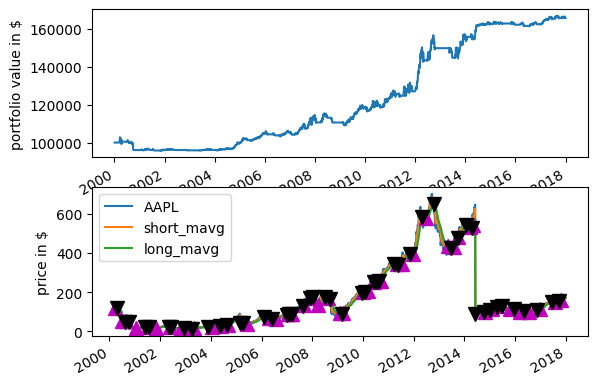

In [22]:
perf = run_algorithm(
    start=start,
    end=end,
    initialize=initialize,
    handle_data=handle_data,
    analyze=analyze,
    capital_base=100000,
    benchmark_returns=benchmark_returns,
    bundle="quandl",
    data_frequency="daily",
)

In [25]:
perf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4528 entries, 2000-01-03 00:00:00+00:00 to 2017-12-29 00:00:00+00:00
Data columns (total 40 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   period_open              4528 non-null   datetime64[ns, UTC]
 1   period_close             4528 non-null   datetime64[ns, UTC]
 2   starting_cash            4528 non-null   float64            
 3   pnl                      4528 non-null   float64            
 4   net_leverage             4528 non-null   float64            
 5   starting_value           4528 non-null   float64            
 6   positions                4528 non-null   object             
 7   short_exposure           4528 non-null   float64            
 8   portfolio_value          4528 non-null   float64            
 9   shorts_count             4528 non-null   int64              
 10  long_exposure            4528 non-null   float64

Now that the backtest is finished, use PyFolio to get a breakdown of the results.

In [23]:
returns, positions, transactions = \
    pf.utils.extract_rets_pos_txn_from_zipline(perf)

This creates a full tear sheet based on your backtest results. There’s a ton of information here, but here are the highlights:

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,7.73,2012-09-19,2013-09-16,2013-12-03,315
1,6.91,2000-03-22,2001-10-31,2005-09-26,1439
2,5.36,2008-05-13,2009-03-20,2009-07-31,319
3,5.06,2012-04-09,2012-04-24,2012-08-17,95
4,3.87,2011-07-26,2011-08-08,2011-09-19,40


Stress Events,mean,min,max
Dotcom,-0.00%,-1.02%,1.21%
Lehman,-0.05%,-0.56%,0.10%
9/11,0.00%,0.00%,0.00%
US downgrade/European Debt Crisis,-0.01%,-1.61%,1.67%
Fukushima,-0.00%,-1.23%,0.70%
US Housing,0.00%,0.00%,0.00%
EZB IR Event,-0.11%,-1.15%,1.06%
Aug07,-0.04%,-0.70%,0.47%
Mar08,0.03%,-0.00%,0.55%
Sept08,-0.07%,-0.56%,0.07%


Top 10 long positions of all time,max
sid,
AAPL,44.89%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
AAPL,44.89%


Summary stats,All trades,Short trades,Long trades
Total number of round_trips,48.00,35.00,13.00
Percent profitable,0.29,0.20,0.54
Winning round_trips,14.00,7.00,7.00
Losing round_trips,34.00,28.00,6.00
Even round_trips,0.00,0.00,0.00


PnL stats,All trades,Short trades,Long trades
Total profit,$-25151.60,$-22898.60,$-2253.00
Gross profit,$31917.00,$29250.00,$2667.00
Gross loss,$-57068.60,$-52148.60,$-4920.00
Profit factor,$0.56,$0.56,$0.54
Avg. trade net profit,$-523.99,$-654.25,$-173.31
Avg. winning trade,$2279.79,$4178.57,$381.00
Avg. losing trade,$-1678.49,$-1862.45,$-820.00
Ratio Avg. Win:Avg. Loss,$1.36,$2.24,$0.46
Largest winning trade,$18178.00,$18178.00,$1037.00
Largest losing trade,$-6740.00,$-6740.00,$-3864.00


Duration stats,All trades,Short trades,Long trades
Avg duration,157 days 00:57:30,183 days 06:51:25.714285714,86 days 09:04:36.923076923
Median duration,48 days 00:00:00,48 days 00:00:00,47 days 00:00:00
Longest duration,937 days 23:00:00,937 days 23:00:00,194 days 01:00:00
Shortest duration,1 days 00:00:00,1 days 00:00:00,8 days 00:00:00


Return stats,All trades,Short trades,Long trades
Avg returns all round_trips,-0.42%,-0.46%,1.01%
Avg returns winning,2.80%,3.05%,1.01%
Avg returns losing,-1.33%,-1.33%,NaN
Median returns all round_trips,-0.76%,-0.77%,1.01%
Median returns winning,1.31%,1.60%,1.01%
Median returns losing,-1.24%,-1.24%,NaN
Largest winning trade,12.15%,12.15%,1.01%
Largest losing trade,-4.35%,-4.35%,1.01%


Symbol stats,AAPL
Avg returns all round_trips,-0.42%
Avg returns winning,2.80%
Avg returns losing,-1.33%
Median returns all round_trips,-0.76%
Median returns winning,1.31%
Median returns losing,-1.24%
Largest winning trade,12.15%
Largest losing trade,-4.35%


Profitability (PnL / PnL total) per name,
symbol,
AAPL,100.00%


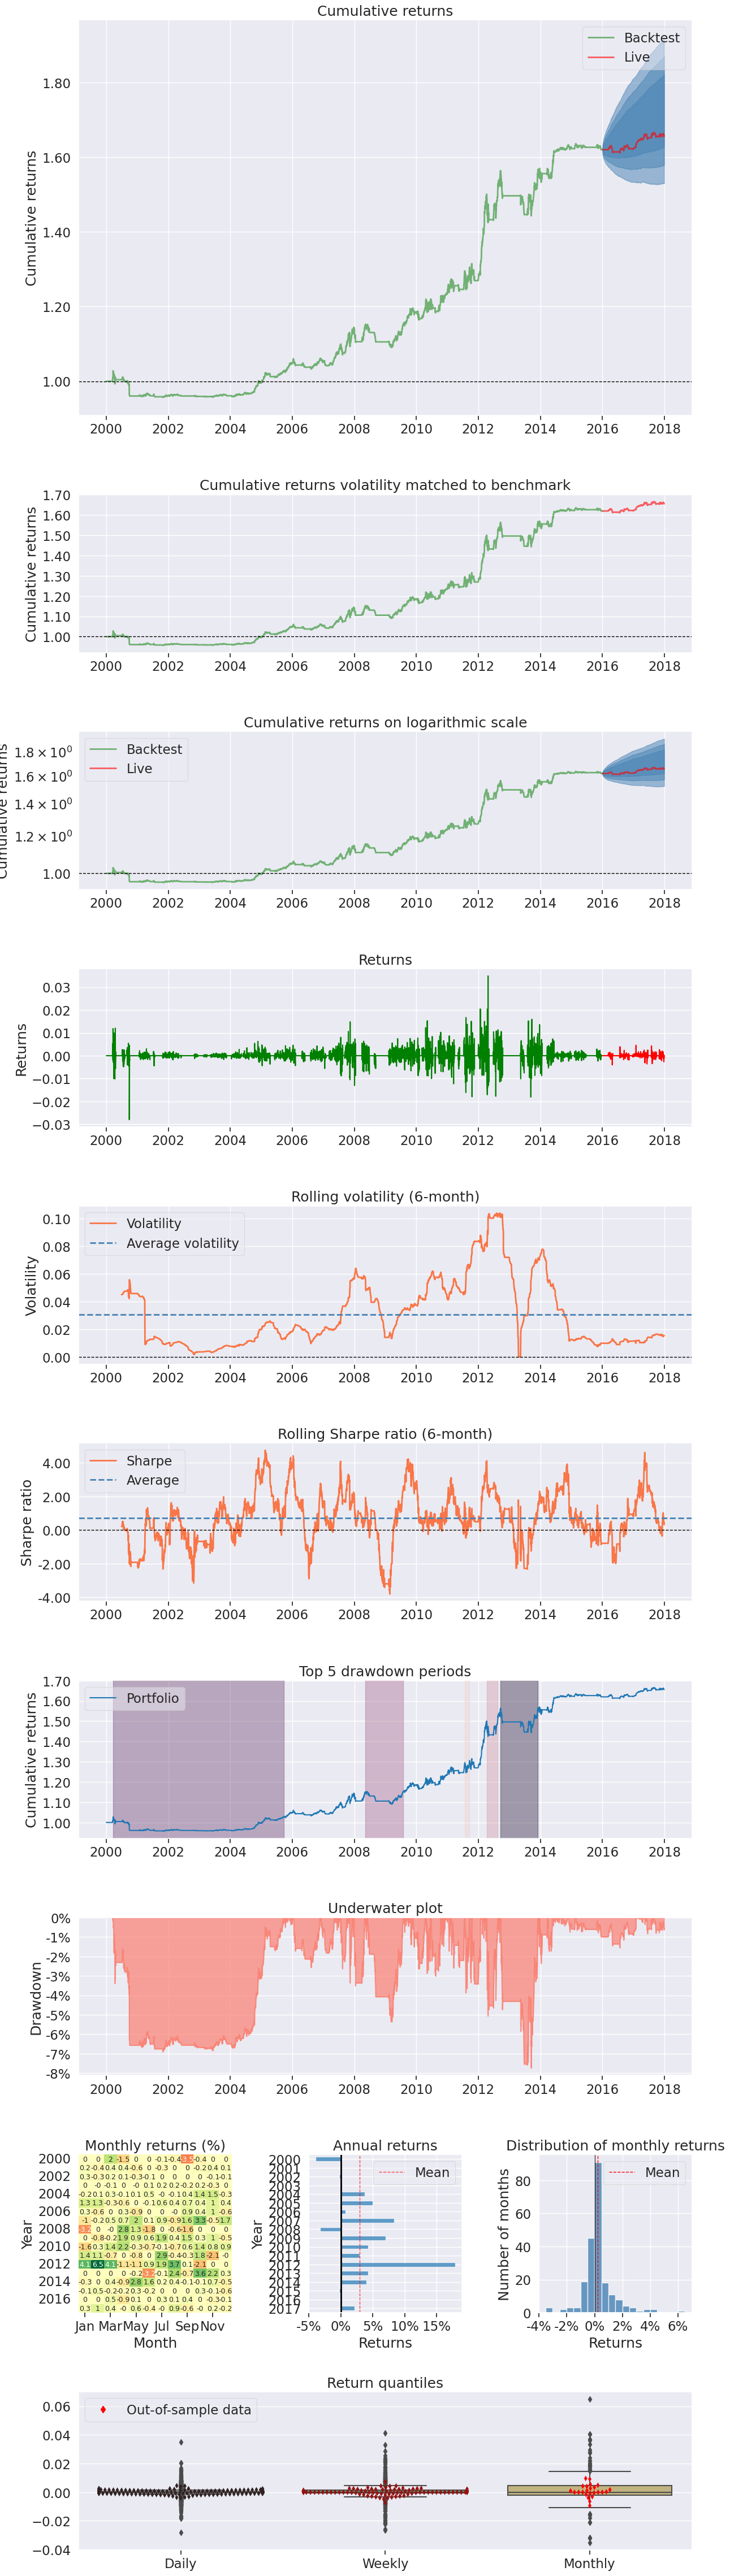

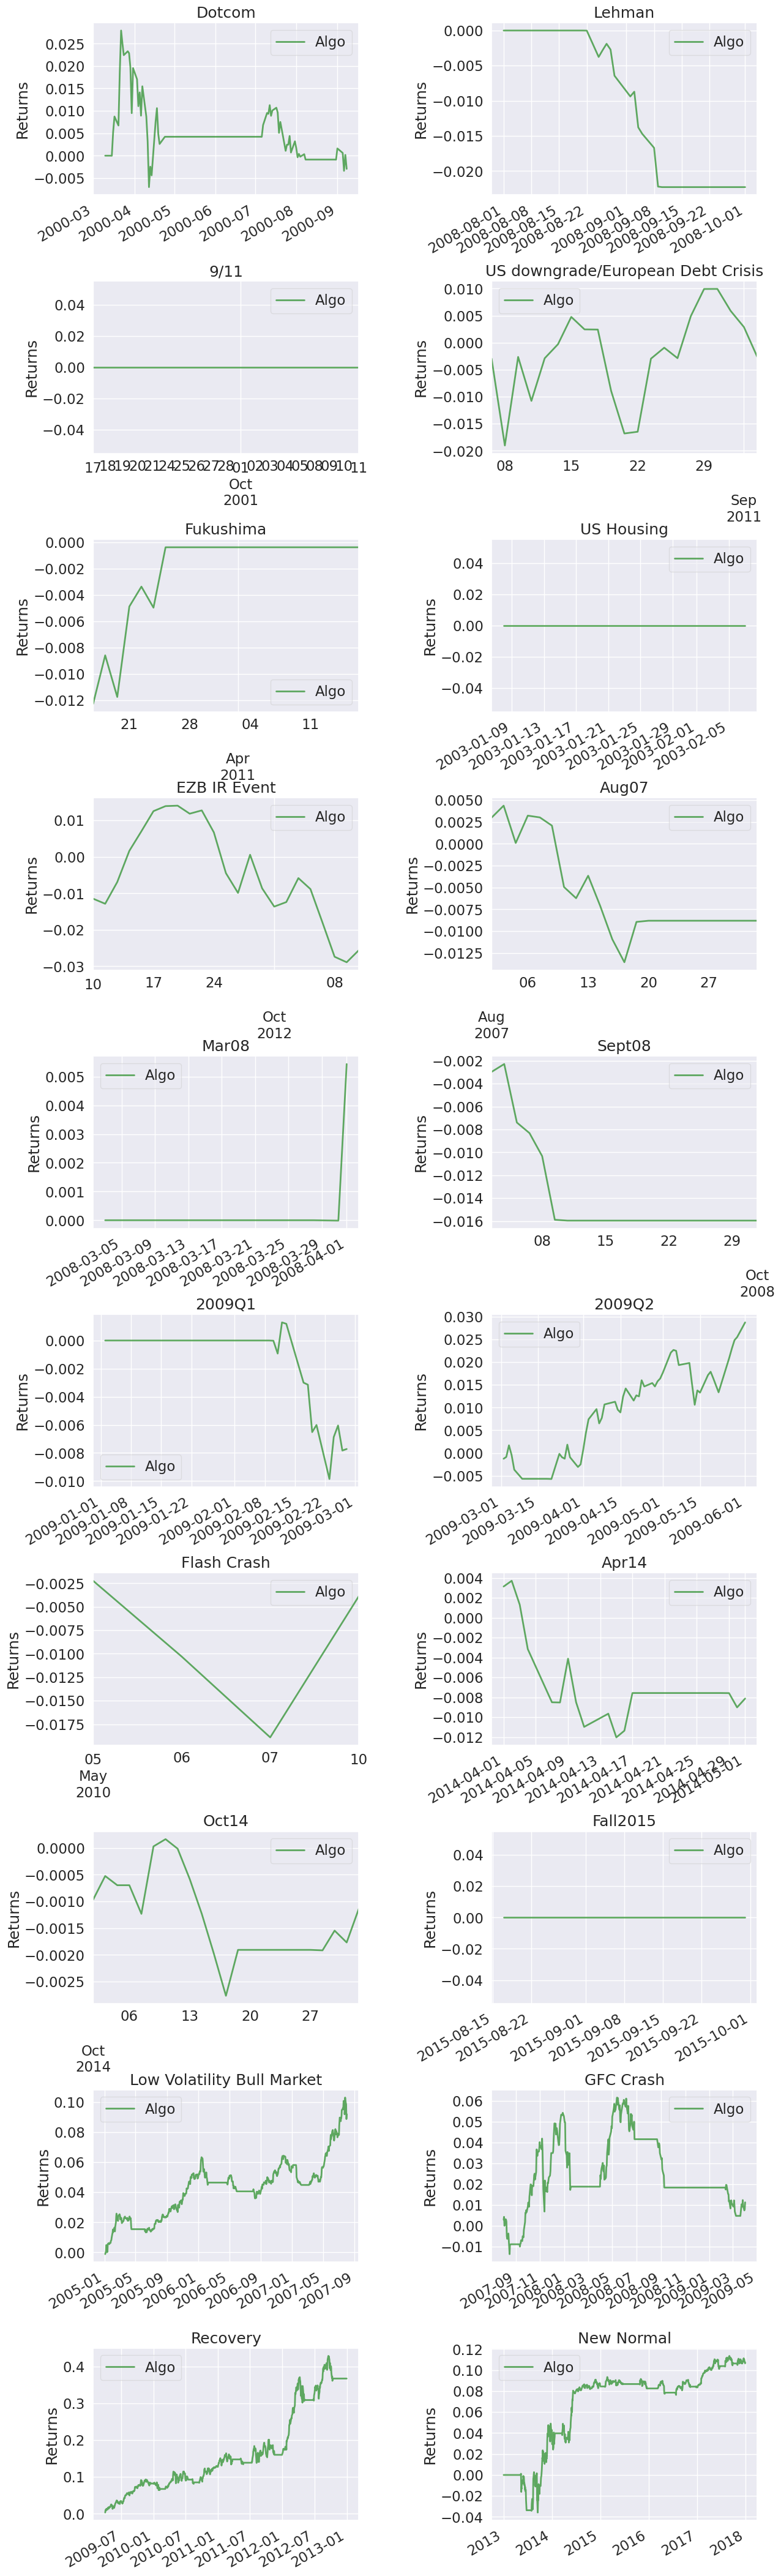

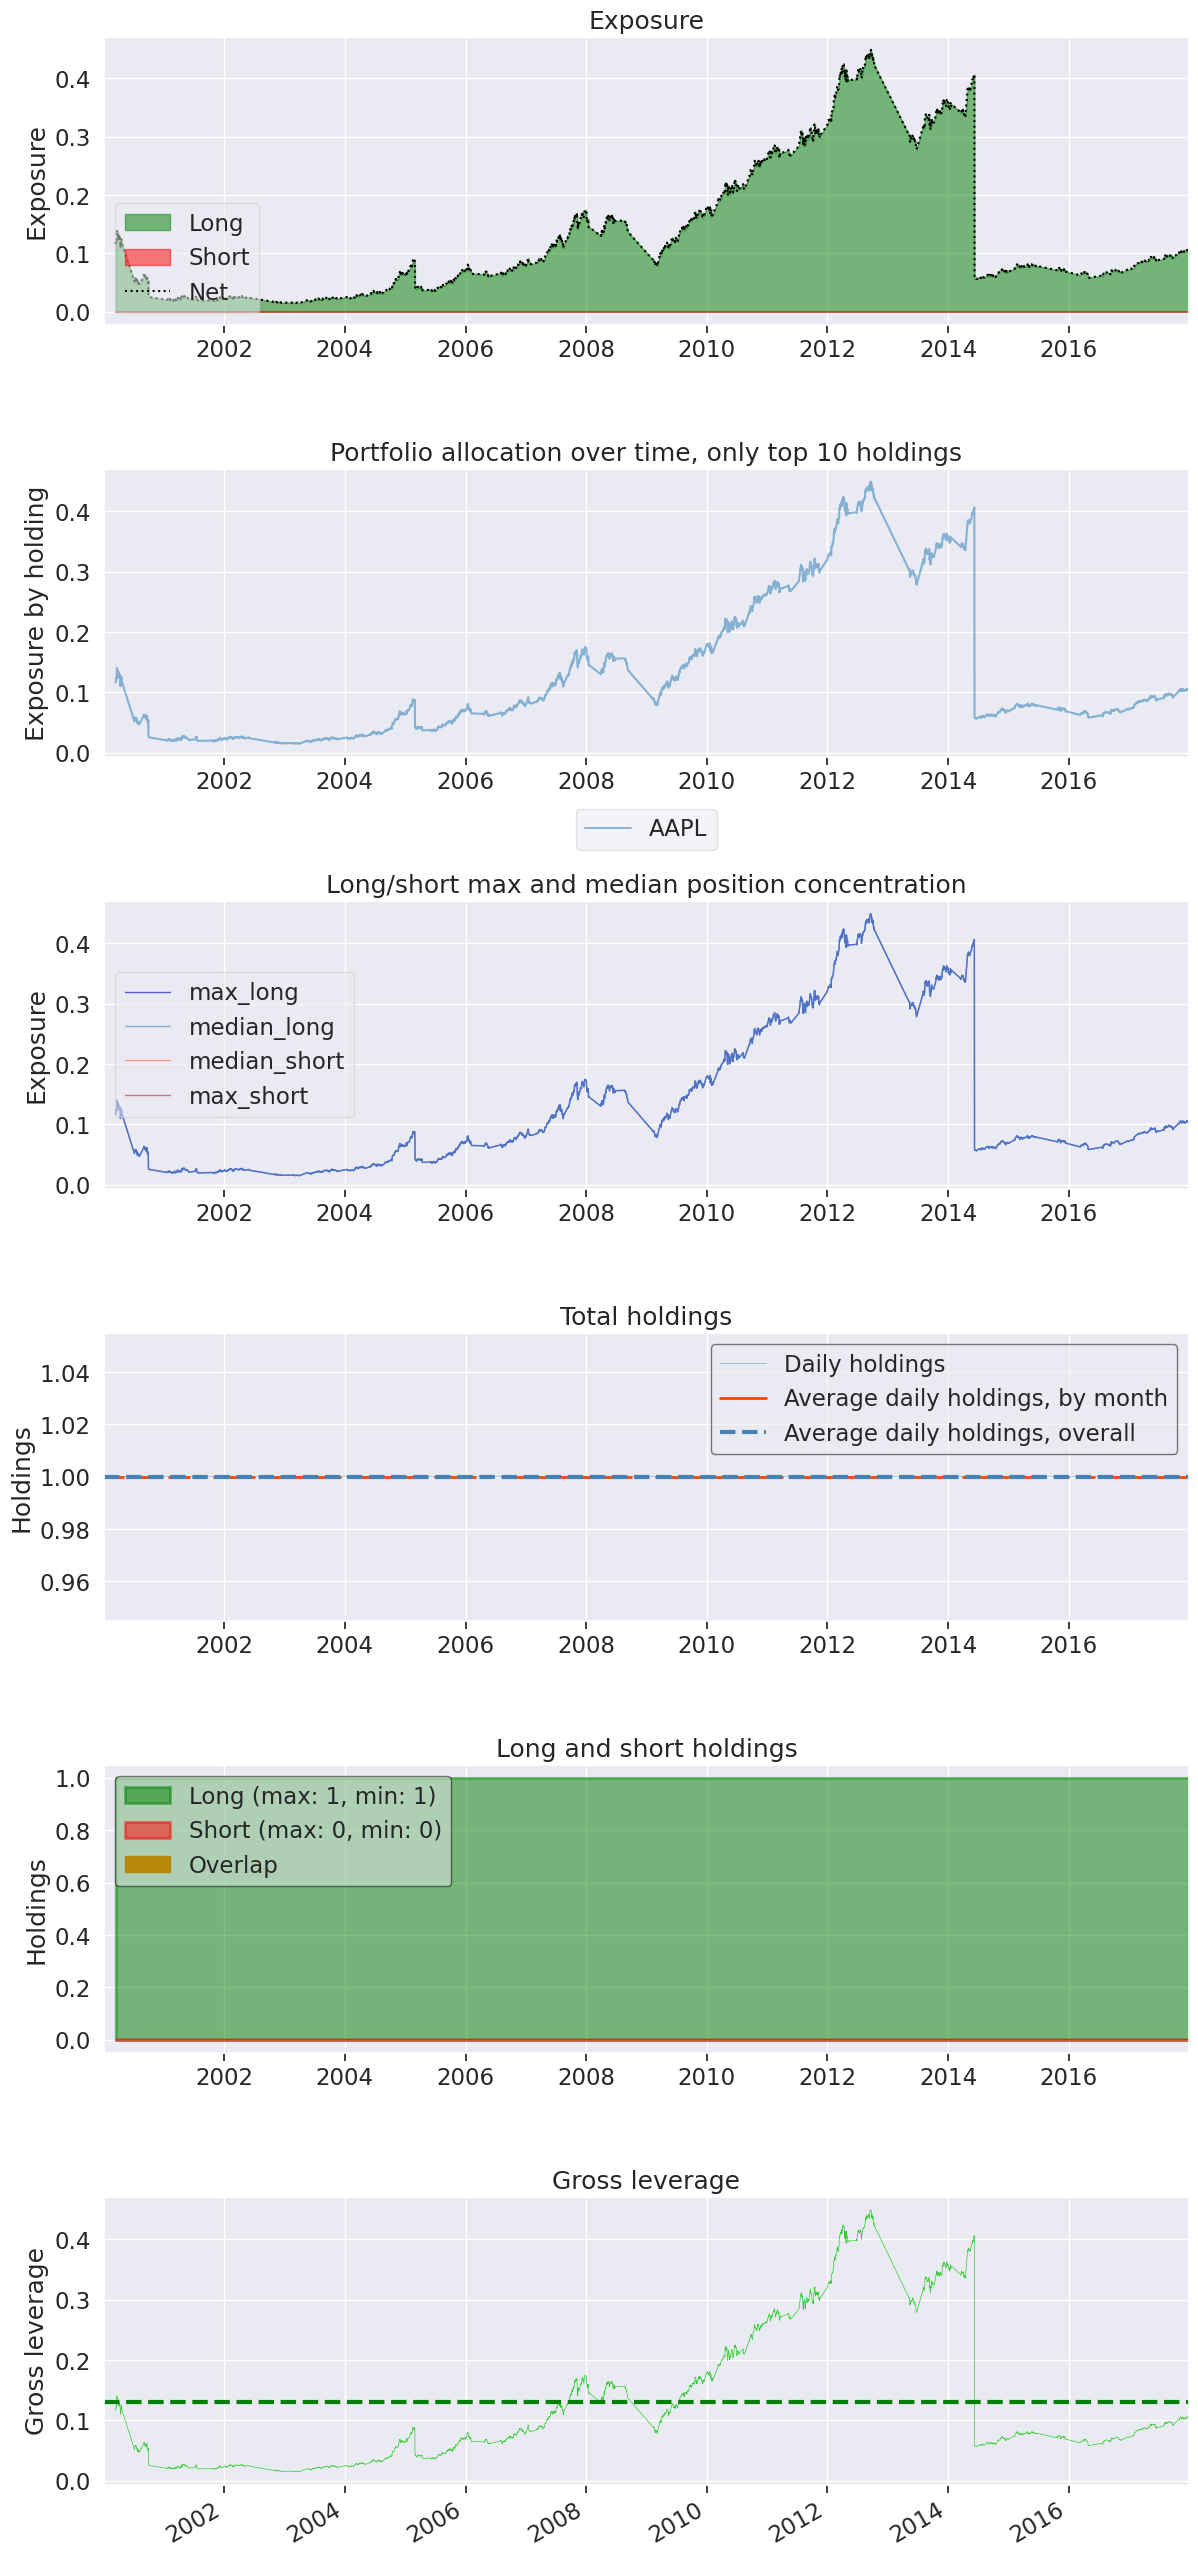

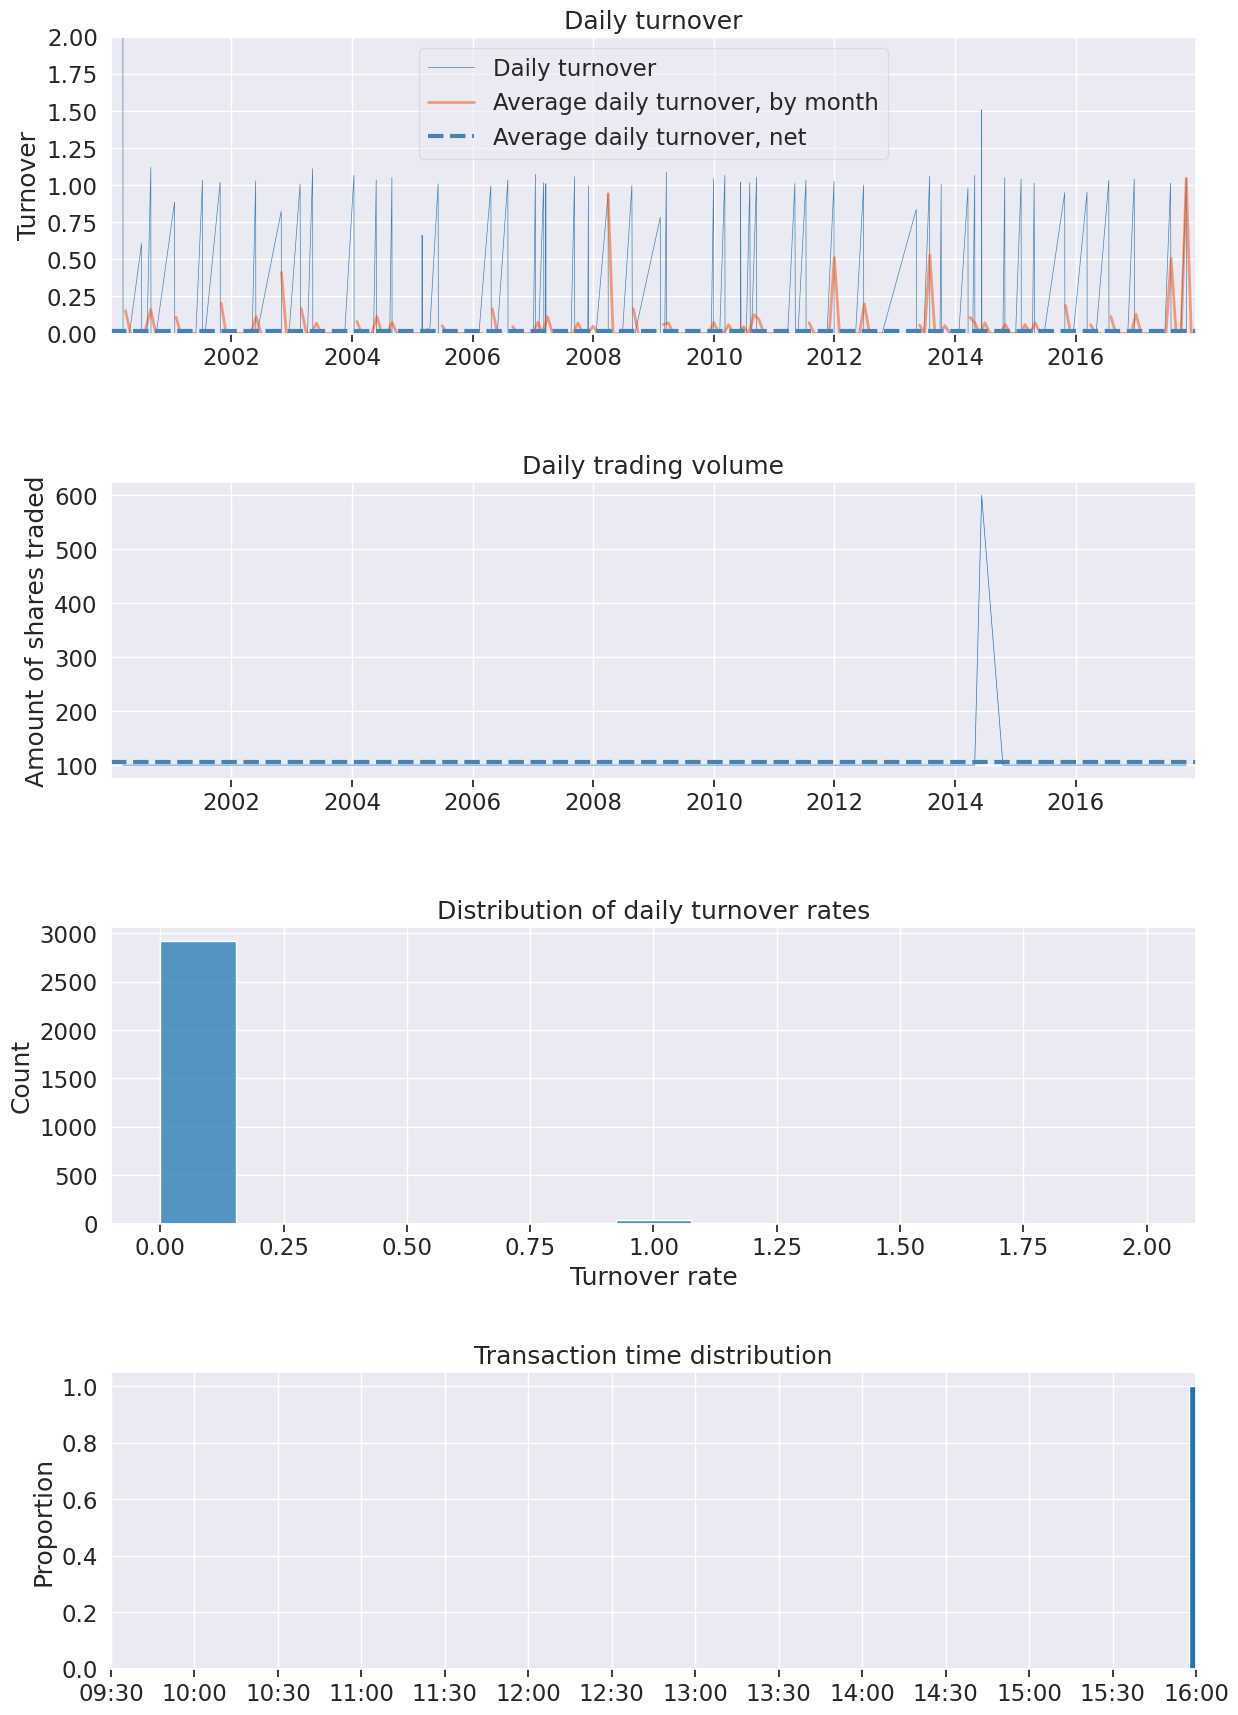

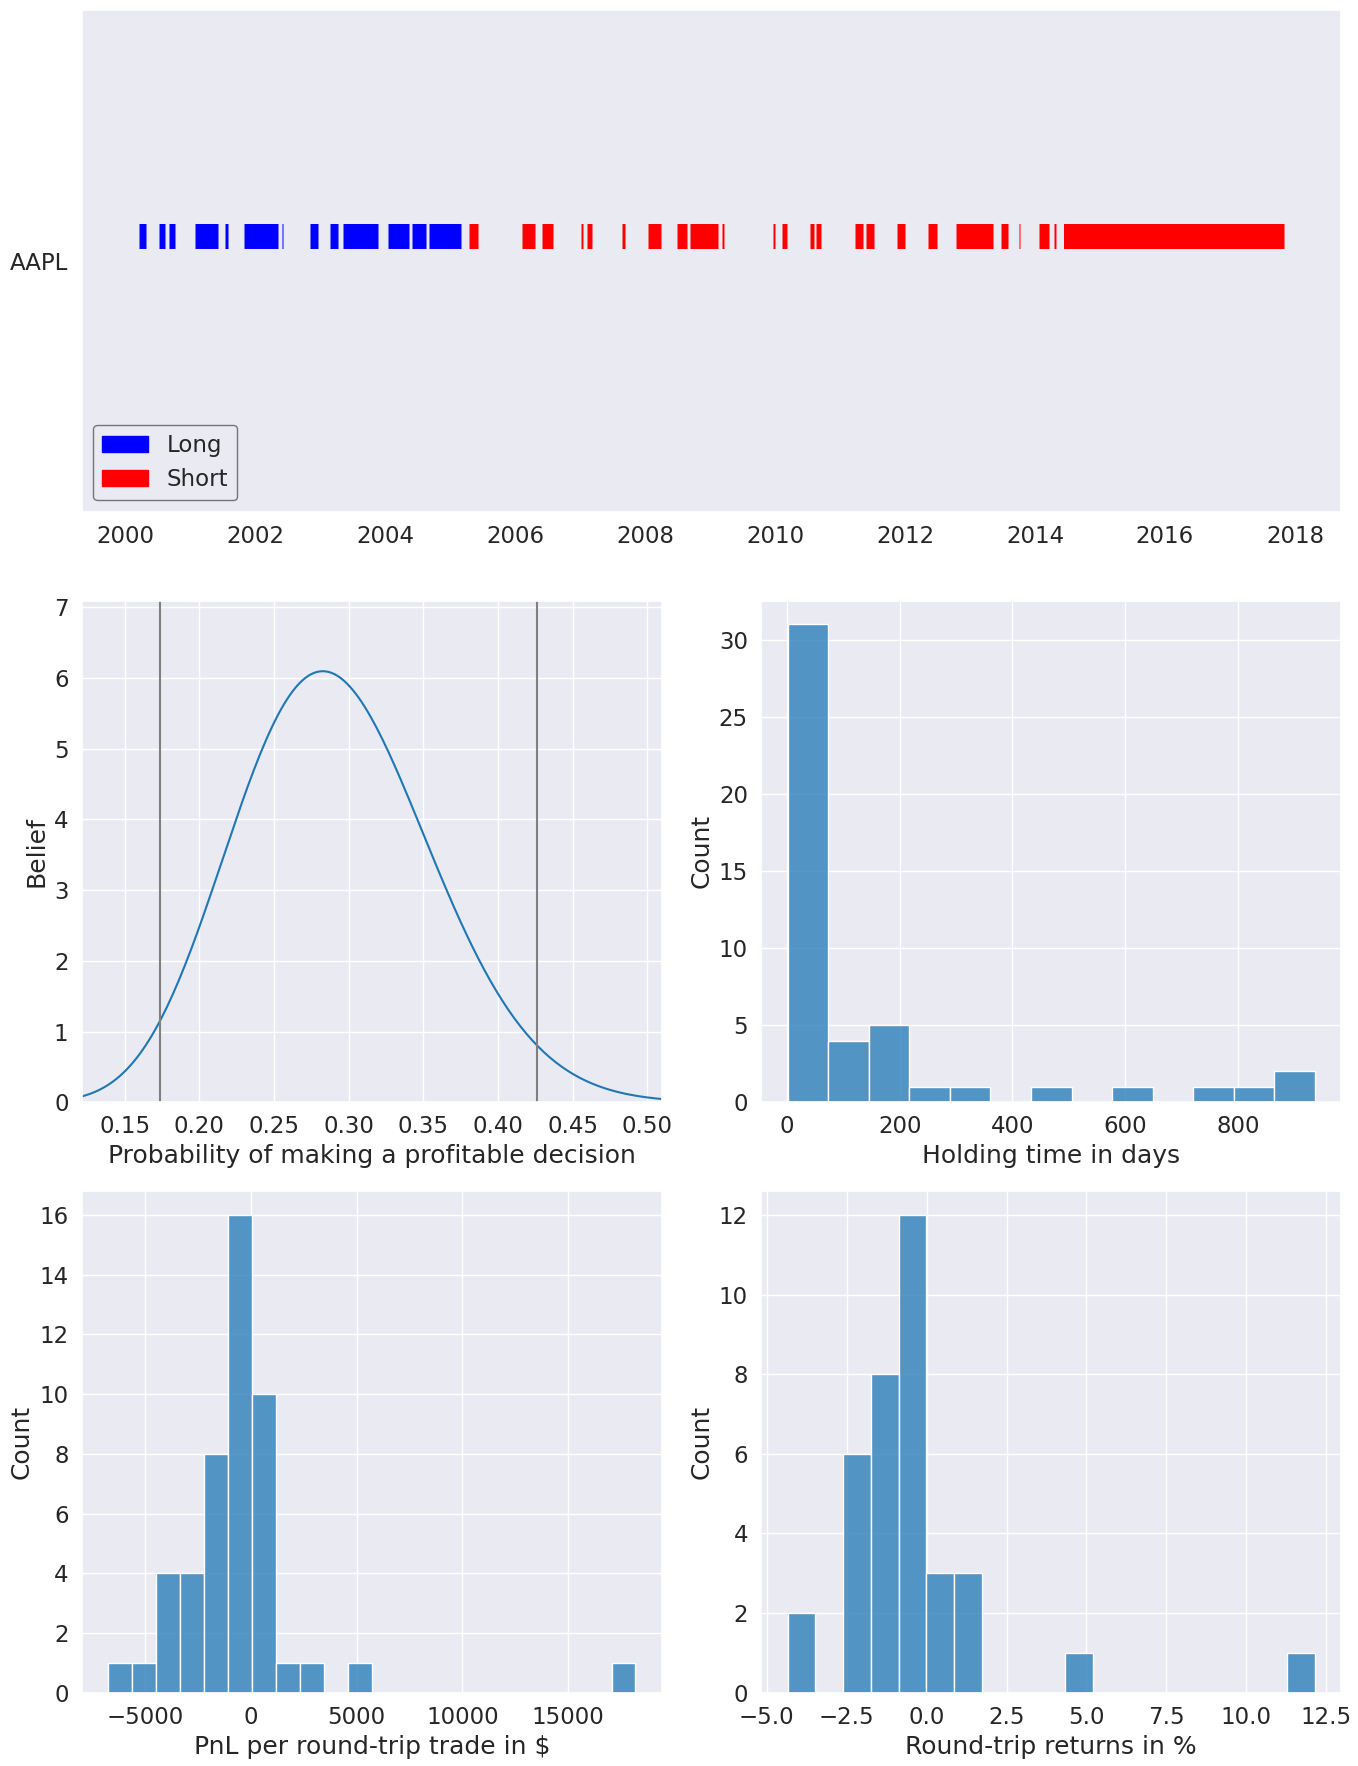

In [24]:
pf.create_full_tear_sheet(
    returns,
    positions=positions,
    transactions=transactions,
    live_start_date="2016-01-01",
    round_trips=True,
)